## Описание проекта
__Проект Телекоммуникации__ \
Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Установка доп. библиотек

In [64]:
!pip install phik
!pip install seaborn==0.12.2

## Импорт библиотек

In [64]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from phik import report

## Загрузка данных

In [65]:
path = '/datasets/'

### contract

In [66]:
contract = pd.read_csv(path + 'contract_new.csv',)
display(contract.head(3))
contract.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Пропусков нет.\
Столбец `TotalCharges` не сконвертировался в числовой формат.\
Проверяю на наличие недопустимых значений в этом столбце.

In [67]:
contract.TotalCharges.sort_values().unique()

array([' ', '100.17', '100.19', ..., '998.89', '999.6', '999.9'],
      dtype=object)

Вывожу строки с пропусками `' '`

In [68]:
contract[contract.TotalCharges == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Это новые пользователи с датой регистрации, равной дате выгрузки базы данных -- 1 февраля 2020.\
Для них нужно будет посавить значение = 0.

__Проверка на корректность значений__

In [69]:
for i in contract.columns:
    print(contract[i].sort_values().unique())

['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
['2013-10-01' '2013-11-01' '2013-12-01' '2014-01-01' '2014-02-01'
 '2014-03-01' '2014-04-01' '2014-05-01' '2014-06-01' '2014-07-01'
 '2014-08-01' '2014-09-01' '2014-10-01' '2014-11-01' '2014-12-01'
 '2015-01-01' '2015-02-01' '2015-03-01' '2015-04-01' '2015-05-01'
 '2015-06-01' '2015-07-01' '2015-08-01' '2015-09-01' '2015-10-01'
 '2015-11-01' '2015-12-01' '2016-01-01' '2016-02-01' '2016-03-01'
 '2016-04-01' '2016-05-01' '2016-06-01' '2016-07-01' '2016-08-01'
 '2016-09-01' '2016-10-01' '2016-11-01' '2016-12-01' '2017-01-01'
 '2017-02-01' '2017-03-01' '2017-04-01' '2017-05-01' '2017-06-01'
 '2017-07-01' '2017-08-01' '2017-09-01' '2017-10-01' '2017-11-01'
 '2017-12-01' '2018-01-01' '2018-02-01' '2018-03-01' '2018-04-01'
 '2018-05-01' '2018-06-01' '2018-07-01' '2018-08-01' '2018-09-01'
 '2018-10-01' '2018-11-01' '2018-12-01' '2019-01-01' '2019-02-01'
 '2019-03-01' '2019-04-01' '2019-05-01' '2019-06-01' '201

---
__Вывод__ :
* NaN значений нет;
* Есть строковые пропуски в последнем столбце, которые не дают сконвертировать данные в числовой формат;
* Дату нужно сконвертировать в `datetime`.

### personal

In [70]:
personal = pd.read_csv(path + 'personal_new.csv',)
display(personal.head(3))
personal.info()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


__Проверка на корректность значений__

In [71]:
for i in personal.columns:
    print(personal[i].sort_values().unique())

['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
['Female' 'Male']
[0 1]
['No' 'Yes']
['No' 'Yes']


---
__Вывод__ : 
* NaN значений нет;
* Все ОК.

### internet
Подключение м. б. 2-х типов: через телефонную линию (DSL) или оптоволоконный кабель (Fiber optic).

In [72]:
internet = pd.read_csv(path + 'internet_new.csv')
display(internet.head(3))
internet.info()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


__Проверка на корректность значений__

In [73]:
for i in internet.columns:
    print(internet[i].sort_values().unique())

['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
['DSL' 'Fiber optic']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']


---
__Вывод__ : 
* NaN значений нет;
* Некоторые из признаков м.б. малоинформативными -- `PaperlessBilling`, `PaymentMethod` ...\
Вероятно придется удалить.

### phone
Подключение телефонного аппарата к нескольким линиям одновременно.

In [74]:
phone = pd.read_csv(path + 'phone_new.csv')
display(phone.head(3))
phone.info()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


__Проверка на корректность значений__

In [75]:
phone.MultipleLines.sort_values().unique()

array(['No', 'Yes'], dtype=object)

---
__Вывод__ : 
* NaN значений нет;
* Все ОК.

## План_работы

1. Базы данных не содержат NaN значений

2. `contract.TotalCharges` не сконвертировалась в числовой формат, т.к. содержит пробелы.\
Заменю их на нули, т.к. это новые пользователи.

3. Объединю все базы данных по полю `customerID`

4. Создам дополнительный признак -- сколько времени клиент у оператора.\
`EndDate - BeginDate` для ушедших\
`CurrentDate - BeginDate` для действующих

5. Закодирую категориальные признаки One-Hot encoder

6. Возможно удалю часть признаков, как малоинфоративные:\
`PaperlessBilling`, `PaymentMethod` ...

7. Это задача бинарной классификации.\
Целевой признак получаю из `contract['EndDate']`\
`IF value = "No" then 0` клиент действующий\
`IF value != "No" then 1` клиент ушел\
Вероятность, что клиент уйдет `= model.predict_proba(features)`

8. Попробую несколько моделей.

9. Предварительную проверку буду делать кроссвалидацией.


## Предварительная обработка

### Пропуски в столбце ТotalCharges

[План_работы п.2](#План_работы)\
Пропуски в столбце `TotalCharges` заменяю нулями.

Перевожу столбец `BeginDate` в формат `datetime`.

In [76]:
contract = pd.read_csv(
    path + 'contract_new.csv',
    converters={'TotalCharges': lambda x: 0 if x == ' ' else float(x)},
    parse_dates=['BeginDate'])

In [77]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


### Объединяю базы данных

In [78]:
df = pd.merge(contract, personal, how='left', on='customerID')
df = pd.merge(df, internet, how='left', on='customerID')
df = pd.merge(df, phone, how='left', on='customerID')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

### Создание признака Duration
[План_работы п.4](#План_работы)\
Создаю столбец с длительностью пребывания у оператора (дни). 

In [79]:
# Дата выгрузки базы данных
date_current = pd.Timestamp('2020-02-01')

# Функция принимает на вход значения из столбцов BeginDate и EndDate
# Возвращает число дней

f = lambda x: (date_current - x[0]).days if x[1] == 'No' \
                else (pd.Timestamp(x[1]) - x[0]).days

In [80]:
df['Duration'] = df[['BeginDate', 'EndDate']].apply(f, axis=1)

df[['BeginDate', 'EndDate','Duration']][7:11]

,BeginDate,EndDate,Duration
7,2019-04-01,No,306
8,2017-07-01,No,945
9,2014-12-01,2017-05-01,882
10,2019-01-01,No,396


### Целевой признак
[План_работы п.7](#План_работы)\
Создаю целевой признак на основе данных из столбца `EndDate`.

In [81]:
df['Target'] = np.where(df.EndDate == 'No', 0, 1)

In [82]:
df[['EndDate','Target']][7:11]

,EndDate,Target
7,No,0
8,No,0
9,2017-05-01,1
10,No,0


### Заглушки
Ставлю заглушки вместо NaN, появившихся после объединения баз данных.

In [83]:
df = df.fillna('n/a')

### Проверка на дубликаты

In [84]:
df.shape

(7043, 22)

In [85]:
df = df.drop_duplicates()
df.shape

(7043, 22)

Дубликатов строк нет

### Удаление столбцов

In [86]:
df = df.drop(['customerID','EndDate'], axis=1)

### Категор. признаки в category
Перевожу категориальные признаки в формат `category`, чтобы можно было обработать встроенным кодировщиком модели. 

In [87]:
df.SeniorCitizen = df.SeniorCitizen.astype('object')
categorical = df.select_dtypes('object').columns
df[categorical] = df[categorical].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   Type              7043 non-null   category      
 2   PaperlessBilling  7043 non-null   category      
 3   PaymentMethod     7043 non-null   category      
 4   MonthlyCharges    7043 non-null   float64       
 5   TotalCharges      7043 non-null   float64       
 6   gender            7043 non-null   category      
 7   SeniorCitizen     7043 non-null   category      
 8   Partner           7043 non-null   category      
 9   Dependents        7043 non-null   category      
 10  InternetService   7043 non-null   category      
 11  OnlineSecurity    7043 non-null   category      
 12  OnlineBackup      7043 non-null   category      
 13  DeviceProtection  7043 non-null   category      
 14  TechSupport       7043 n

### Визуализация признаков

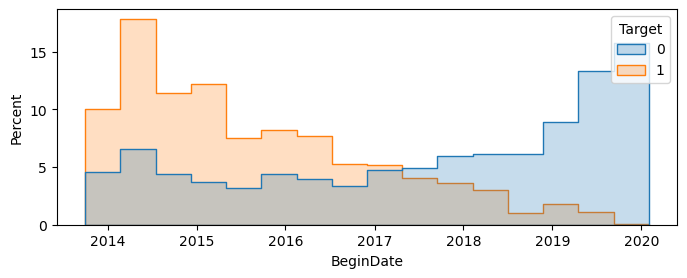

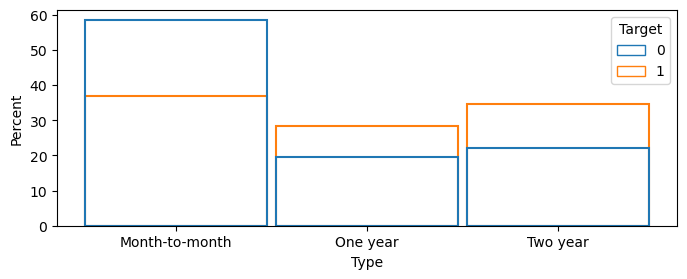

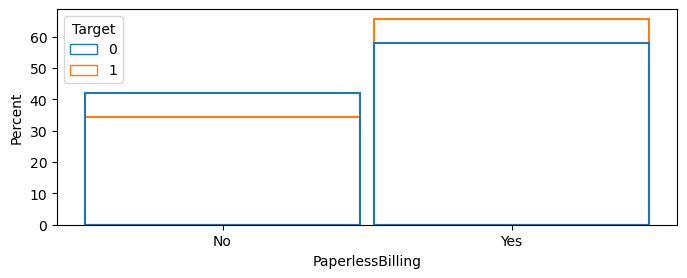

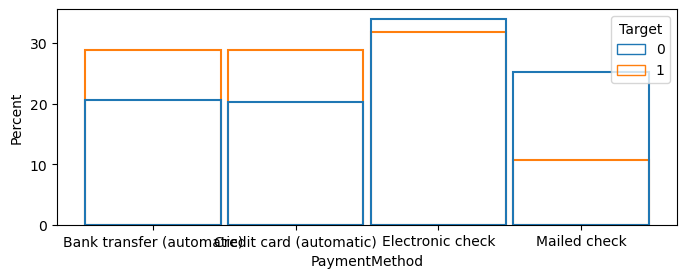

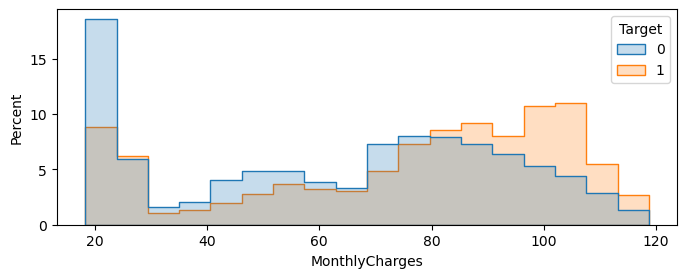

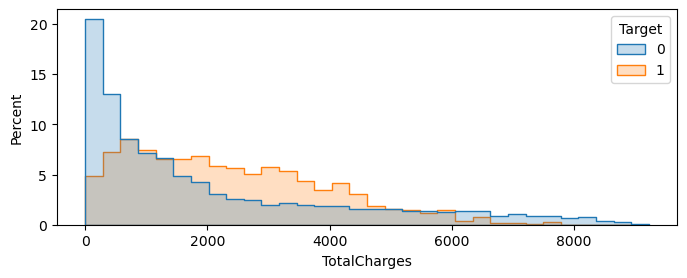

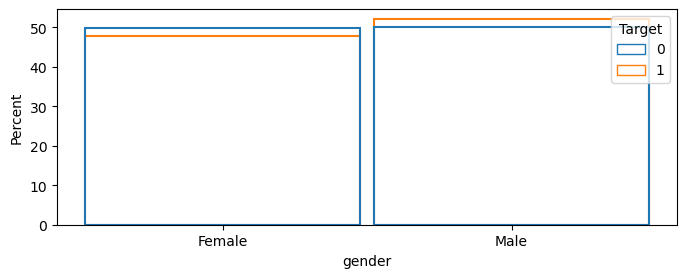

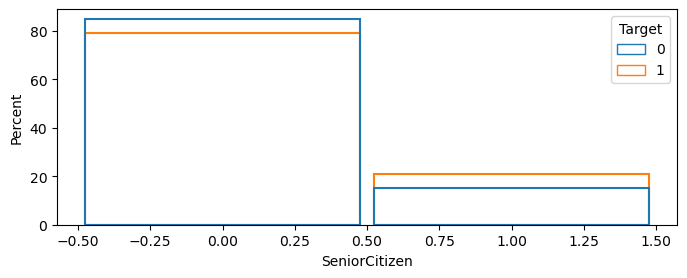

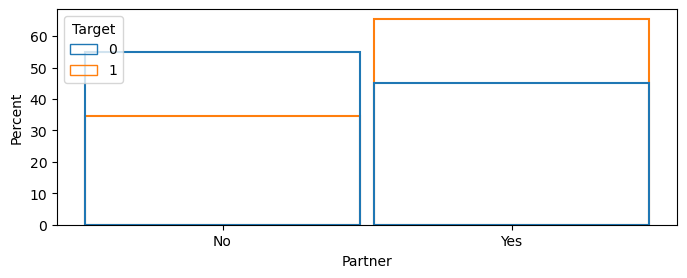

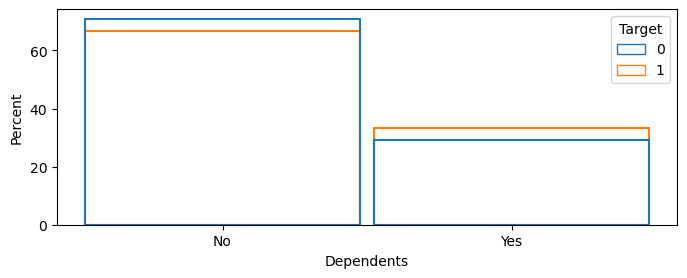

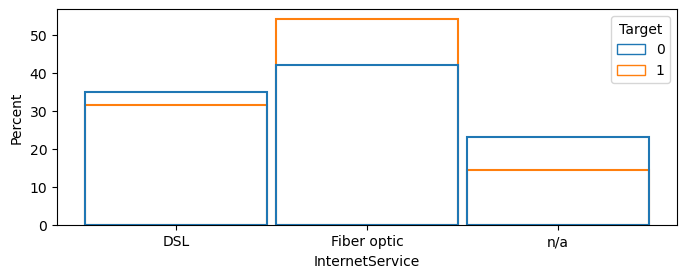

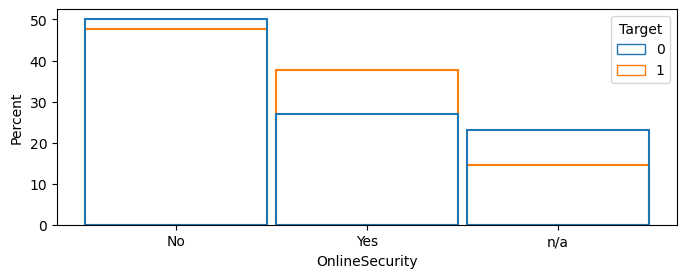

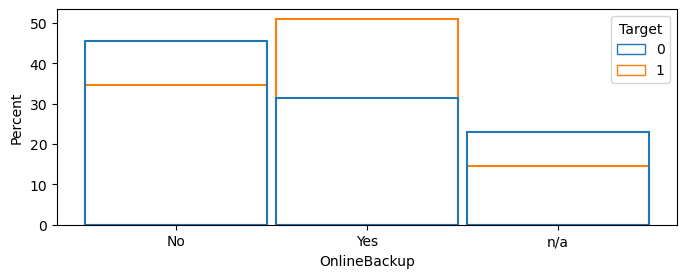

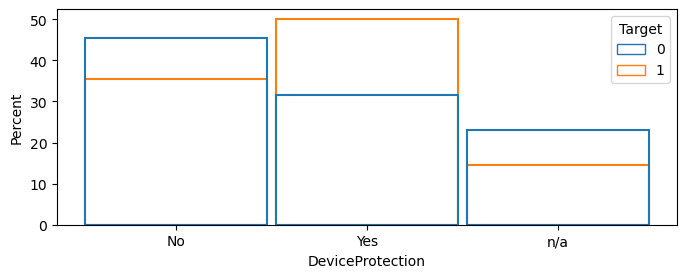

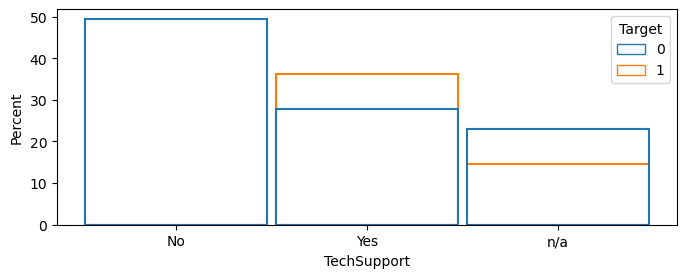

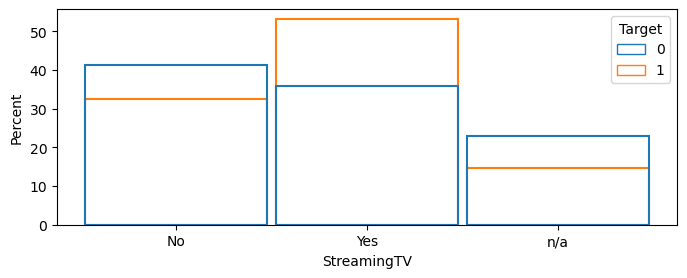

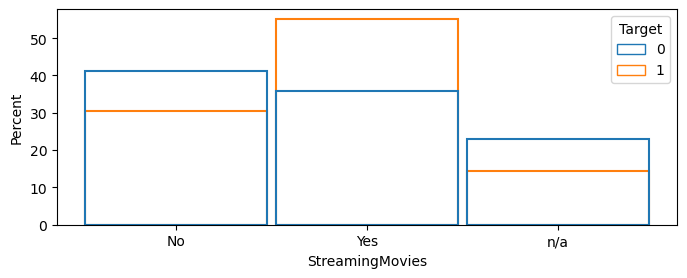

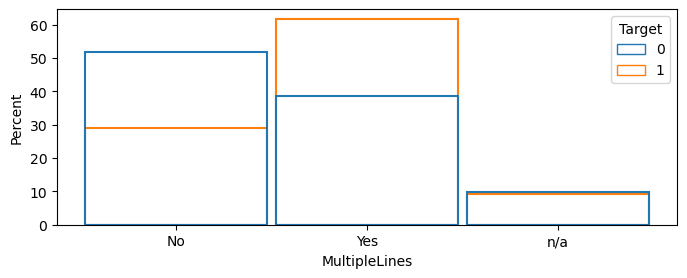

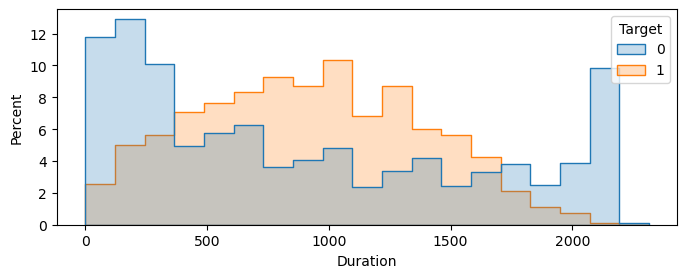

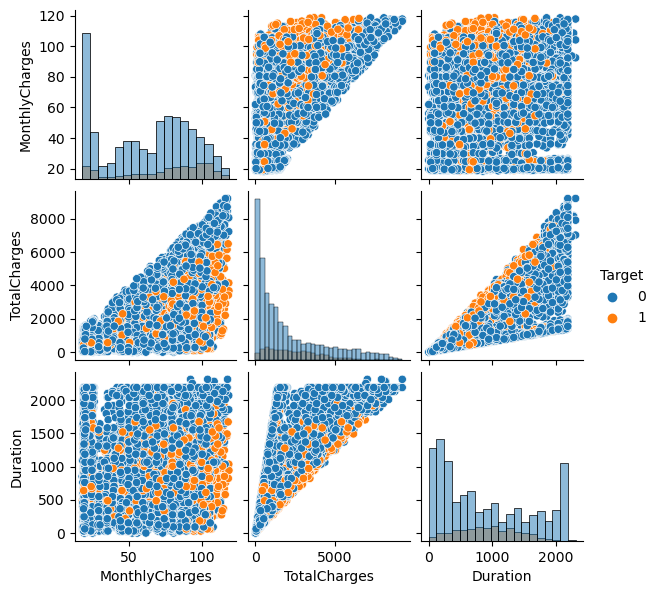

In [88]:
for col in df.columns[:-1]:
    plt.figure(figsize=(8,2.8))
    if col in df.columns[[0,4,5,18]]: 
        element='step'
        fill = True
        shrink=1
    else: 
        element = 'bars' 
        fill = False
        shrink=0.95
    sns.histplot(df, x=col, hue='Target', 
                 common_norm=False, stat='percent', element=element, fill=fill, shrink=shrink)
    plt.show()
    
sns.pairplot(df, 
             diag_kind='hist',
             x_vars=['MonthlyCharges','TotalCharges','Duration'],
             y_vars=['MonthlyCharges','TotalCharges','Duration'],
             hue='Target', height=2)
plt.show()

__Выводы:__

|Признак|Нелояльный vs Лояльный клиент|
|:--|:--|
|BeginDate|Чем раньше стал клиентом, тем более вероятно, что уйдет|
|Type of payment| Меньше любят помесячную оплату|
|PaperlessBilling|Б'ольшая склонность к электронным счетам|
|PaymentMethod|Предпочитают электронные способы оплаты|
|MonthlyCharges|Преобладают клиенты с большими расходами|
|TotalCharges|Преобладают клиенты с большими расходами|
|gender|Чуть больше мужчин|
|SeniorCitizen|Чуть больше пенсионеров|
|Partner|Преобладают семейные|
|Dependents|Чуть больше иждивенцев|
|Internet<br>(как услуга)|Больше пользователей<br> (меньше пропусков в полях, относящихся к Интернету)|
|InternetService|Больше любят Fiber Optic|
|OnlineSecurity<br>OnlineBackup<br>DeviceProtection<br>TechSupport<br>StreamingTV<br>StreamingMovies|Больше пользователей|
|MultipleLines|Больше пользователей|
|Duration|Больше клиентов со средним временем - в середине распределения,<br>в то время как у лояльных пользователей преобладают новички и старожилы|
|диаграмма<br> _PairPlot_|Данные на графике _TotalCharges vs Duration_ образовали клин между двумя линиями: клиенты с наименьшими и наибольшими возможными расходами.<br> Ушедшие клиенты концентрируются около линии с наибольшими расходами|

На графиках BeginDate и Duration видны небольшие выбросы.

In [89]:
(df.BeginDate < '2013-12-16').sum()

8

In [90]:
(df.Duration >= 2200).sum()

6

Возможно их удалю из обучающей выборки.

### Удаляю BeginDate

In [92]:
df = df.drop('BeginDate', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Type              7043 non-null   category
 1   PaperlessBilling  7043 non-null   category
 2   PaymentMethod     7043 non-null   category
 3   MonthlyCharges    7043 non-null   float64 
 4   TotalCharges      7043 non-null   float64 
 5   gender            7043 non-null   category
 6   SeniorCitizen     7043 non-null   category
 7   Partner           7043 non-null   category
 8   Dependents        7043 non-null   category
 9   InternetService   7043 non-null   category
 10  OnlineSecurity    7043 non-null   category
 11  OnlineBackup      7043 non-null   category
 12  DeviceProtection  7043 non-null   category
 13  TechSupport       7043 non-null   category
 14  StreamingTV       7043 non-null   category
 15  StreamingMovies   7043 non-null   category
 16  MultipleLines     7043 n

### Features и Target
Делю на признаки и целевой признак.

In [93]:
X = df.drop('Target', axis=1)
y = df.Target

### Train и Test
Делю на обучающую и тестовую выборки

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=30723)

In [95]:
X_train.shape, X_test.shape

((5282, 18), (1761, 18))

## Анализ_на_коллинеарность

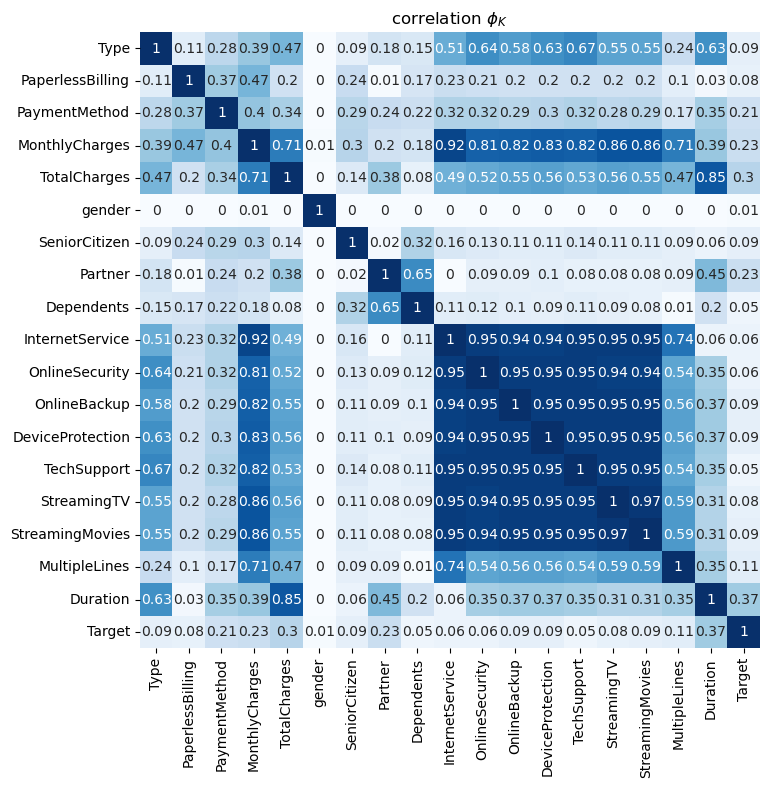

In [96]:
interval_cols = ['MonthlyCharges', 'TotalCharges', 'Duration', 'Target']
phik_overview= df.phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(8,8))
sns.heatmap(phik_overview.round(2),
            cbar=False, cmap='Blues', annot=True)
plt.title('correlation $\phi_K$');

__Выводы__ \
Все признаки из базы данных Internet с сильной коллинеарностью.\
Со столбцом InternetService также сильно коррелирует MonthlyCharges.\
Ниже попробую удалить данные столбцы, оставив только InternetService.

## Выбор Модели на полном наборе признаков

### LGBMClassifier

In [97]:
%%time
params = dict(num_leaves=[15, 17, 19],
              learning_rate=[0.25, 0.3, 0.35],
              n_estimators=[140, 150, 160],
              reg_lambda=[1,2,3] ,
              reg_alpha=[0, 0.5] ,
              num_threads=[1]#Код ревьюера
             )

model = LGBMClassifier(random_state=30723)

gridsearch = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1)

best_lgbm = gridsearch.fit(X_train, y_train)
best_lgbm.best_params_, best_lgbm.best_score_

[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
CPU times: total: 4.83 s
Wall time: 19.9 s


({'learning_rate': 0.25,
  'n_estimators': 150,
  'num_leaves': 15,
  'num_threads': 1,
  'reg_alpha': 0.5,
  'reg_lambda': 1},
 0.8906997229687601)

### CatBoostClassifier

In [98]:
%%time
params = dict(learning_rate=[0.15, 0.2, 0.25],
              iterations=[130, 140, 150],
              l2_leaf_reg=[0,1,2] )

cat_features = X_train.select_dtypes('category').columns.tolist()

model = CatBoostClassifier(cat_features=cat_features, logging_level='Silent',random_state=30723)

gridsearch = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1)

best_catboost = gridsearch.fit(X_train, y_train)
best_catboost.best_params_, best_catboost.best_score_

CPU times: total: 7.58 s
Wall time: 1min 6s


({'iterations': 150, 'l2_leaf_reg': 0, 'learning_rate': 0.25},
 0.8833623412114004)

### Результат

Для тестирования беру LGBM модель.\
Результат немного лучше и время подбора параметров у LGBM значительно меньше:\
18 VS 66 сек при большем кол-ве параметров подбора у LGBM.

## Проверка модели на уменьшенном кол-ве признаков

Удаляю признаки с коэф. корреляции >= 0.92. См. [Анализ на коллинеарность](#Анализ_на_коллинеарность)

In [99]:
X_train_cutted = X_train.drop(['OnlineSecurity',
                         'OnlineBackup', 
                         'DeviceProtection',
                         'TechSupport',
                         'StreamingTV',
                         'StreamingMovies',
                         'MonthlyCharges'], axis=1)

X_test_cutted = X_test.drop(['OnlineSecurity',
                         'OnlineBackup', 
                         'DeviceProtection',
                         'TechSupport',
                         'StreamingTV',
                         'StreamingMovies',
                         'MonthlyCharges'], axis=1)

In [100]:
%%time
params = dict(num_leaves=[13, 15, 17],
              learning_rate=[0.25, 0.3, 0.35],
              n_estimators=[140, 150, 160],
              reg_lambda=[0, 1,2] ,
              reg_alpha=[0, 0.5, 1] ,
              num_threads=[1]#Код ревьюера
             )

model = LGBMClassifier(random_state=30723)

gridsearch = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1)

best_lgbm_1 = gridsearch.fit(X_train_cutted, y_train)
best_lgbm_1.best_params_, best_lgbm_1.best_score_

CPU times: total: 3.53 s
Wall time: 19.4 s


({'learning_rate': 0.3,
  'n_estimators': 150,
  'num_leaves': 15,
  'num_threads': 1,
  'reg_alpha': 0.5,
  'reg_lambda': 1},
 0.9017458011745803)

__Вывод__ \
На меньшем кол-ве признаков модель показала лучше результат.\
Тестировать буду ее.

## Тестирование модели

### Значение ROC_AUC

In [102]:
y_predict_proba = best_lgbm_1.predict_proba(X_test_cutted)[:, 1]
roc_auc_score(y_test, y_predict_proba)

0.928030266909514

### ROC кривая

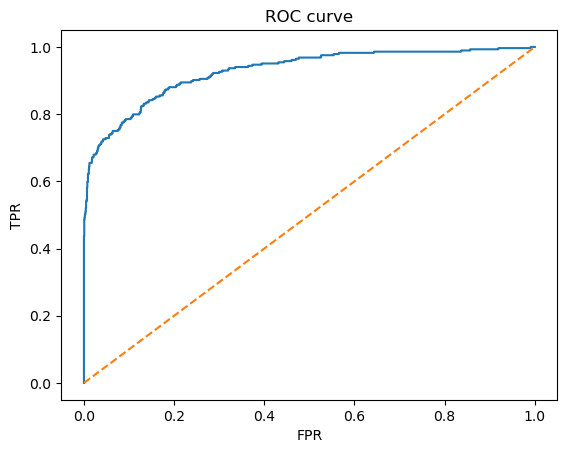

In [103]:
FPR, TPR, _ = roc_curve(y_test, y_predict_proba)

plt.plot(FPR, TPR)
plt.plot([0, 1], linestyle='--')
plt.xlabel('FPR'), plt.ylabel('TPR'), plt.title('ROC curve');

### Матрица Ошибок

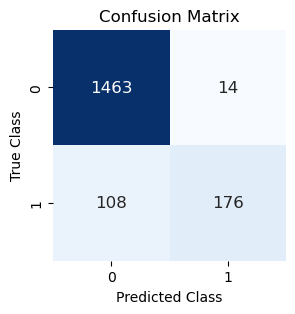

In [105]:
matrix = confusion_matrix(y_test, best_lgbm_1.predict(X_test_cutted))
plt.figure(figsize=(3,3))
sns.heatmap(matrix, cmap='Blues', cbar=False, 
            annot=True, fmt='.0f', annot_kws=dict(size=12))
plt.title("Confusion Matrix")
plt.ylabel("True Class"), plt.xlabel("Predicted Class");

### Анализ важности признаков

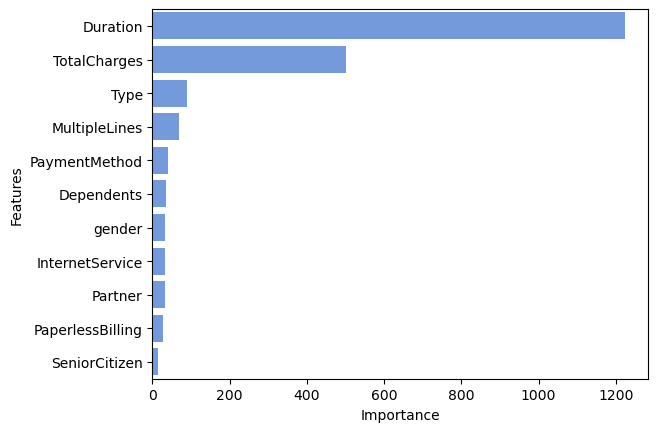

In [106]:
feature_importances = best_lgbm_1.best_estimator_.feature_importances_

order=X_train_cutted.columns[feature_importances.argsort()[::-1]].tolist()

sns.barplot(x=feature_importances, y=X_train_cutted.columns, order=order, color='cornflowerblue')
plt.ylabel('Features'), plt.xlabel('Importance');

### Выводы

Цель достигнута: ROC_AUC = 0.93.

Численные признаки в топе по важности с большим отрывом от категориальных.\
Наиболее важный признак -- длительность пребывания клиентом компании.

## Отчёт по решению

>Какие пункты плана были выполнены, а какие — нет. Почему?

Не выполнил следующие пункты:
* _5. Закодирую категориальные признаки One-Hot encoder_ \
Использовал встроенные кодировщики моделей.
* _8. Попробую несколько моделей. Начну с Логистической регрессии._ \
Логистическую регрессию пробовать не стал, чтобы не терять время. Метод старый, модель не имеет встроенного кодировщика. Вместо этого протестирвал две популярные модели градиентного бустинга.

>Какие трудности возникли и как вы их преодолели?

Задание выполнял на своем компьютере.\
На проверке у ревьюера код выдал ошибку, т.к. я использовал свежую версию plotly.  
Переделал все графики на seaborn и для перестраховки предварительно проверил на тренажере.\
Снова ошибка.\
Вспомнил про совет Сергея, загружать через pip нужные библиотеки.\
Сделал — снова ошибка в тренажере.\
В итоге, сообразил перезапустить ядро тренажера, чтобы оно "увидело" нужную библиотеку.

>Какие ключевые шаги в решении задачи вы выделили?

* Создание доп. признака Duration.\
Без него цель вряд ли была бы достигнута;
* Проверка на мультиколлинеарность.\
Столкнулся только на проекте. В теории об этом не говорилось.\
Очень понравилось. Позволило доп. улучшить итоговую модель.
* Выбор хороших кандидатов для модели.\
Градиентный бустинг со встроенными кодировщиками признаков рулит :).

> Какие признаки использовали для обучения модели

Проверил 2 набора признаков:
* Полный
* Частичный — удалил 7 признаков\
По итогам анализа на мультиколлинеарность удалил 6 признаков из БД Интернет, за исключением `InternetService`. И еще удалил `MonthlyCharges`, т.к. он был сильно скоррелирован с `InternetService`.



> Какая предобработка этих признаков была выполнена?

* Перевод дат в формат `datetime` для создания признака Duration;
* Обработка пропусков в TotalCharges.
* Поставил заглушки на место пропусков, образовавшихся после объединения таблиц.
* Перевел столбцы с категориальными признаками в формат `category`, чтобы в дальнейшем их мог обработать встроенный кодировщик LightGBM.

>Какая ваша итоговая модель?

`LGBMClassifier`

> Какие у неё гиперпараметры?

In [118]:
best_lgbm_1.best_estimator_.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.25,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 140,
 'n_jobs': -1,
 'num_leaves': 15,
 'objective': None,
 'random_state': 30723,
 'reg_alpha': 0,
 'reg_lambda': 0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'num_threads': 1}

>  Какое качество?

ROC_AUC = 0.928030266909514